In [41]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import re

In [42]:
# import NLTK and download required resources
import nltk
# nltk.download('punkt')  # For tokenization
# nltk.download('stopwords')  # For stop words
# nltk.download('wordnet')  # For lemmatization
# nltk.download('omw-1.4')  # For lemmatizer's extended language support

In [43]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [44]:
import sklearn

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
%ls data

cigar_aficionado.csv  clean_cigar_eda.csv   corpus_data.csv


python3.12(18368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [47]:
feature_columns = ['cigar_id', 'name', 'score', 'length', 'gauge', 'tasting_notes',
       'shape', 'filler', 'binder', 'wrapper', 'country', 'strength', 'usd_value', 'issue', 'issue_date']

In [48]:
data = pd.read_csv('/Users/djbetts/Documents/data_science/projects/top-25-cigars/data/clean_cigar_eda.csv', usecols=feature_columns)

In [49]:
df = data.copy()

In [50]:
df.columns

Index(['cigar_id', 'name', 'score', 'length', 'gauge', 'tasting_notes',
       'shape', 'filler', 'binder', 'wrapper', 'country', 'strength', 'issue',
       'issue_date', 'usd_value'],
      dtype='object')

In [51]:
df[df['tasting_notes'].isna()].head()

,cigar_id,name,score,length,gauge,tasting_notes,shape,filler,binder,wrapper,country,strength,issue,issue_date,usd_value
37,38,PARTAGAS LUSITANIA,92,7.625,49.0,NaN,Double Corona,Cuba,Cuba,Cuba,Cuba,NaN,Cigar Aficionado,1995-03-01,21.645
86,87,JOYA DE NICARAGUA CONSUL,82,4.500,52.0,NaN,Robusto,Nicaragua,Nicaragua,Dominican Republic,Nicaragua,NaN,Cigar Aficionado,1998-12-01,4.000
1033,1037,DON JUAN PLATINUM TORPEDO,87,6.000,52.0,NaN,Figurado,"Dominican Republic, Nicaragua, Honduras",Dominican Republic,USA/Connecticut Shade,Dominican Republic,NaN,Cigar Aficionado,1998-03-01,6.250
1034,1038,PUNCH GRAND CRU NO. 2,87,6.125,54.0,NaN,Figurado,"Honduras, Nicaragua, Dominican Republic",USA/Connecticut Broadleaf,USA/Connecticut Shade,Honduras,NaN,Cigar Aficionado,1998-03-01,9.950
1035,1039,LEÓN JIMENES PETIT BELICOSO,87,5.000,52.0,NaN,Figurado,Dominican Republic,Dominican Republic,USA/Connecticut Shade,Dominican Republic,NaN,Cigar Aficionado,1998-03-01,6.600


In [52]:
df['word_count'] = df['tasting_notes'].apply(lambda x: len(str(x).split()))
average_word_count = df['word_count'].mean()
print(f"Average sentence length (in words): {average_word_count}")

# Example usage:
# word_counts, avg_sentence_length = calculate_word_counts(df, 'column_name')


Average sentence length (in words): 27.650344263084406


In [53]:
df['word_count'].describe()

count    20769.000000
mean        27.650344
std         20.513728
min          1.000000
25%         22.000000
50%         25.000000
75%         29.000000
max        499.000000
Name: word_count, dtype: float64

In [54]:
df[df['word_count'] < 50]['word_count'].mean()

np.float64(25.108550368550368)

<Axes: ylabel='Frequency'>

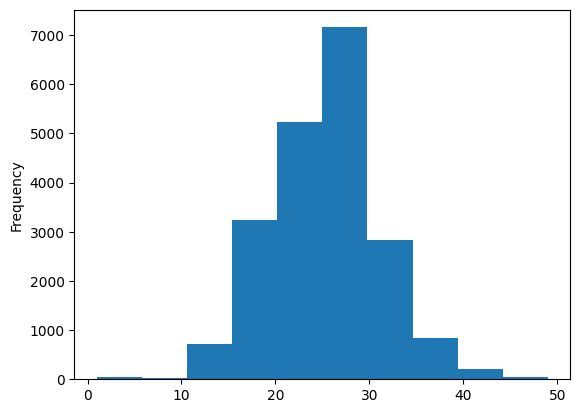

In [55]:
df[df['word_count'] < 50]['word_count'].plot(kind='hist')

In [56]:
#drop NULL 'tasting_notes' rows
df = df[~df['tasting_notes'].isna()]
df.shape

(20722, 16)

In [57]:
#drop NULL only include reviews less than 50 words
df = df[df['word_count'] < 50]
df.shape

(20303, 16)

# remove duplicated tasting_notes repeated in issues

In [58]:
print(df.shape)
df = df.drop_duplicates(subset=['tasting_notes'], keep='first')
df.shape

(20303, 16)


(19039, 16)

In [59]:
# Calculate the value counts for each cigar name
name_counts = df['name'].value_counts()

In [60]:
df['name'].value_counts().nunique()

32

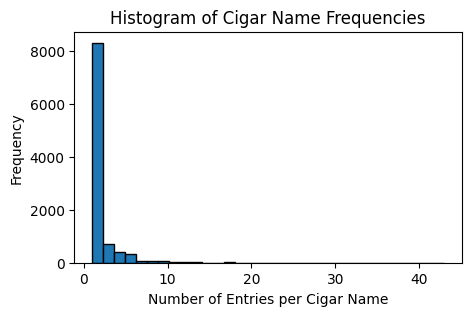

In [61]:
# Plot a histogram of the counts
plt.figure(figsize=(5, 3))
plt.hist(name_counts.values, bins=32, edgecolor='black')
plt.title('Histogram of Cigar Name Frequencies')
plt.xlabel('Number of Entries per Cigar Name')
plt.ylabel('Frequency')
plt.show()

# clean text

In [62]:
def clean_text(text):
      # Check if the input text is null, and return "Null" if true
    if pd.isnull(text):
        return "Null"
    # Remove special characters and HTML tags
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [63]:
df['clean_notes'] = df['tasting_notes'].apply(lambda x: clean_text(x))

In [64]:
df['clean_notes']

0        this is an earthy rich cigar with a lovely bro...
1        an enticing cigar that keeps you coming back f...
2        this cigar is wellmade and gives plenty of fla...
3        this is a clean very mild wellmade cigar with ...
4        finely constructed a fuentes robusto has a nic...
                               ...                        
20763    a softly pressed inkyhued toro with a wellform...
20764    chocolatebrown with a multiseamed cap this thi...
20765    the smoke from this oily robusto imparts a bol...
20766    dark and wellmade with a multiseamed cap and f...
20767    the smoke of this dark oily cigar is somewhat ...
Name: clean_notes, Length: 19039, dtype: object

<Axes: ylabel='Frequency'>

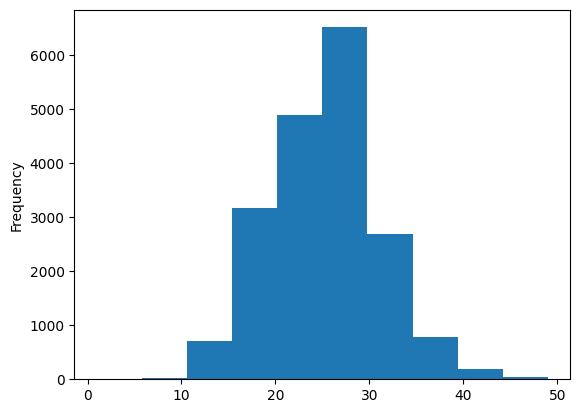

In [65]:
df['word_count'].plot(kind='hist')

# tokenize

In [66]:
# Tokenize each entry in the clean_notes column
df['tokens'] = df['clean_notes'].apply(word_tokenize)
print(df[['clean_notes', 'tokens']].head())

                                         clean_notes  \
0  this is an earthy rich cigar with a lovely bro...   
1  an enticing cigar that keeps you coming back f...   
2  this cigar is wellmade and gives plenty of fla...   
3  this is a clean very mild wellmade cigar with ...   
4  finely constructed a fuentes robusto has a nic...   

                                              tokens  
0  [this, is, an, earthy, rich, cigar, with, a, l...  
1  [an, enticing, cigar, that, keeps, you, coming...  
2  [this, cigar, is, wellmade, and, gives, plenty...  
3  [this, is, a, clean, very, mild, wellmade, cig...  
4  [finely, constructed, a, fuentes, robusto, has...  


# remove stop words

In [67]:
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply stop word removal
df['tokens_no_stopwords'] = df['tokens'].apply(remove_stopwords)
print(df[['tokens', 'tokens_no_stopwords']].head())

                                              tokens  \
0  [this, is, an, earthy, rich, cigar, with, a, l...   
1  [an, enticing, cigar, that, keeps, you, coming...   
2  [this, cigar, is, wellmade, and, gives, plenty...   
3  [this, is, a, clean, very, mild, wellmade, cig...   
4  [finely, constructed, a, fuentes, robusto, has...   

                                 tokens_no_stopwords  
0  [earthy, rich, cigar, lovely, brown, wrapper, ...  
1  [enticing, cigar, keeps, coming, back, beautif...  
2  [cigar, wellmade, gives, plenty, flavor, goes,...  
3  [clean, mild, wellmade, cigar, grassy, earthy,...  
4  [finely, constructed, fuentes, robusto, nice, ...  


# stemming

In [68]:
# stemmer = PorterStemmer()

# # Function to apply stemming
# def apply_stemming(tokens):
#     return [stemmer.stem(word) for word in tokens]

# # Apply stemming
# df['stemmed_tokens'] = df['tokens_no_stopwords'].apply(apply_stemming)
# print(df[['tokens_no_stopwords', 'stemmed_tokens']].head())

# lemmatization

In [69]:
lemmatizer = WordNetLemmatizer()

# Function to apply lemmatization
def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization
df['lemmatized_tokens'] = df['tokens_no_stopwords'].apply(apply_lemmatization)
print(df[['tokens_no_stopwords', 'lemmatized_tokens']].head())

                                 tokens_no_stopwords  \
0  [earthy, rich, cigar, lovely, brown, wrapper, ...   
1  [enticing, cigar, keeps, coming, back, beautif...   
2  [cigar, wellmade, gives, plenty, flavor, goes,...   
3  [clean, mild, wellmade, cigar, grassy, earthy,...   
4  [finely, constructed, fuentes, robusto, nice, ...   

                                   lemmatized_tokens  
0  [earthy, rich, cigar, lovely, brown, wrapper, ...  
1  [enticing, cigar, keep, coming, back, beautifu...  
2  [cigar, wellmade, give, plenty, flavor, go, co...  
3  [clean, mild, wellmade, cigar, grassy, earthy,...  
4  [finely, constructed, fuentes, robusto, nice, ...  


# Vectorization

In [70]:
#rejoin into corpus

# Create the Corpus from Lemmatized Tokens
# Assuming 'lemmatized_tokens' contains lemmatized tokens for each document
df['corpus'] = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Display the corpus to verify
print(df['corpus'].head())

0    earthy rich cigar lovely brown wrapper dense s...
1    enticing cigar keep coming back beautifully ma...
2    cigar wellmade give plenty flavor go coffee li...
3    clean mild wellmade cigar grassy earthy aroma ...
4    finely constructed fuentes robusto nice draw e...
Name: corpus, dtype: object


In [71]:
df.columns

Index(['cigar_id', 'name', 'score', 'length', 'gauge', 'tasting_notes',
       'shape', 'filler', 'binder', 'wrapper', 'country', 'strength', 'issue',
       'issue_date', 'usd_value', 'word_count', 'clean_notes', 'tokens',
       'tokens_no_stopwords', 'lemmatized_tokens', 'corpus'],
      dtype='object')

In [72]:
print(df.shape)
df = df.drop_duplicates(subset=['corpus'], keep='first')
df.shape

(19039, 21)


(18904, 21)

In [73]:
file_name = '/Users/djbetts/Documents/data_science/projects/top-25-cigars/data/corpus_data.csv'
df.to_csv(file_name, index=False)